In [1]:
import sys
sys.path.append("../")

from transformers import AutoTokenizer
from models.clip import CLIPTextTransformer, CLIPVisionTransformer, CLIPModel

In [2]:
import sys
sys.path.append("../")

from models.dataset_utils import make_dataloader, create_input_iter

files = ['../data/tfrecords/observations_1.tfrecord','../data/tfrecords/observations_2.tfrecord','../data/tfrecords/observations_3.tfrecord','../data/tfrecords/observations_4.tfrecord',]
# files = ['../data/observations.tfrecord',]
ds = make_dataloader(files, batch_size=32, seed=42)
batches = create_input_iter(ds)

In [3]:
image, caption = next(iter(ds))

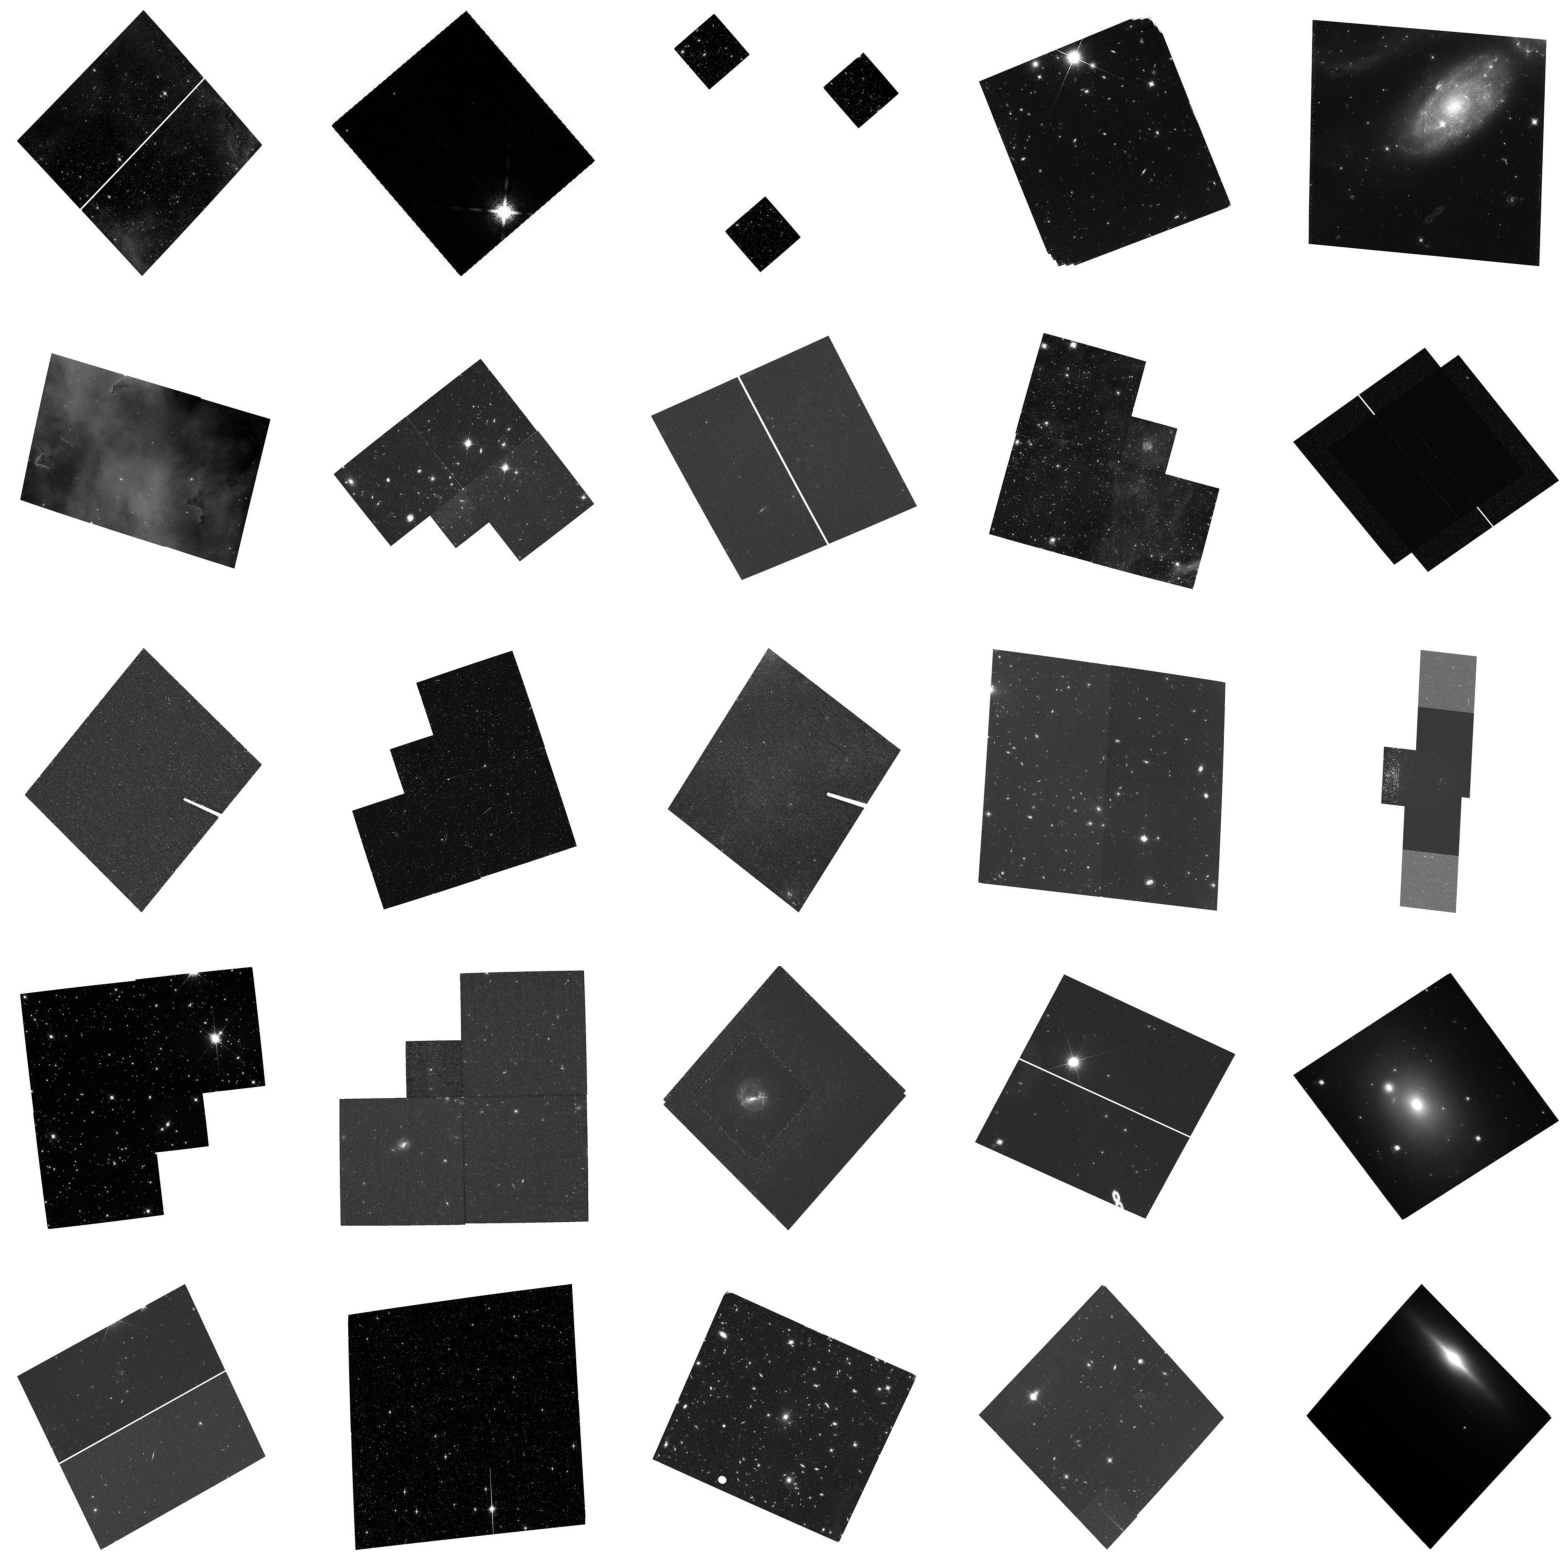

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))

grid_size = 5

# Loop through the images in the batch and plot them in a grid
for i in range(grid_size * grid_size):
    plt.subplot(grid_size, grid_size, i+1)
    plt.imshow(image[i], vmin=0, vmax=1)
    plt.axis('off')  # Turn off axis numbers and ticks

plt.show()

In [5]:
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

caption = caption.numpy().tolist()
caption = [c.decode('utf-8') for c in caption]

txt_inputs = tokenizer(
                    caption,
                    padding="max_length",
                    truncation=True,
                    max_length=10,
                    return_tensors="np",
                )
txt_inputs = {k: txt_inputs[k] for k in ["input_ids", "attention_mask"]}

In [6]:
text_config = {
    "dtype": "float32",
    "activations": ["gelu"],
    "use_bias": False,
    "force_scale": False,
    "attention_dropout": 0.0,
    "mlp_dropout_rate": 0.0,
    "unroll": 100,
    "gradient_checkpointing": False,
    "eos_token_id": 49407,
    "vocab_size": 50000,
    "hidden_size": 512,
    "max_length": 300,
    "num_layers": 4,
    "use_rmsnorm": True,
    "ln_type": "normformer",
    "num_heads": 8,
    "position_embedding_type": "rotary",
    "use_causal_mask": False,
    "mlp_dim": 1024
  }

vision_config ={
  "position_embedding_type": "sincos2d",
  "dtype": "float32",
  "activations": ["gelu"],
  "use_bias": False,
  "force_scale": False,
  "attention_dropout": 0.0,
  "mlp_dropout_rate": 0.0,
  "unroll": 100,
  "gradient_checkpointing": True,
  "image_size": 512,
  "hidden_size": 512,
  "patch_size": 16,
  "num_layers": 4,
  "use_rmsnorm": True,
  "ln_type": "normformer",
  "num_heads": 4,
  "use_causal_mask": False,
  "mlp_dim": 1024
}

In [7]:
transformer = CLIPTextTransformer(**text_config)

In [8]:
import jax

key = jax.random.PRNGKey(0)
output, params = transformer.init_with_output(key, txt_inputs['input_ids'], txt_inputs['attention_mask'])

2023-10-05 10:58:40.170897: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %fusion.5 = (u32[12800000]{0}, u32[12800000]{0}) fusion(), kind=kLoop, calls=%horizontally_fused_computation

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2023-10-05 10:58:40.292008: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.121182497s
Constant folding an instruction is taking > 1s:

  %fusion.5 = (u32[12800000]{0}, u32[12800000]{0}) fusion(), kind=kLoop, calls=%horizontally_fused_computation

This isn't necessarily a bug; constant-folding is inherently a trade-off betwee

In [9]:
vit = CLIPVisionTransformer(**vision_config)

In [10]:
from PIL import Image
import jax.numpy as np
import matplotlib.pyplot as plt

outputs, params = vit.init_with_output(key, image.numpy());

In [11]:
num_local_devices = jax.local_device_count()

batch = {"pixel_values": image.numpy(), "input_ids": txt_inputs['input_ids'], "attention_mask": txt_inputs['attention_mask']}
batch = jax.tree_map(lambda x: np.array(x, dtype=np.float32), batch)
batch = jax.tree_map(lambda x: np.split(x, num_local_devices, axis=0), batch)

In [12]:
clip = CLIPModel(text_config=text_config, vision_config=vision_config, projection_dim=256)

outputs, params = clip.init_with_output(key, np.array(batch["input_ids"])[0], np.array(batch["pixel_values"])[0], np.array(batch["attention_mask"])[0])

In [13]:
import jax
import jax.numpy as np

# Enable float64 for numerical stability
jax.config.update("jax_enable_x64", True)

def mini_batch_sigmoid_loss(text_embeds, image_embeds, logit_scale, logit_bias, negative_samples):
        """Positive samples are on the diagonal"""
        bs = text_embeds.shape[0]
        if negative_samples:
            labels = -np.ones((bs, bs))
        else:
            labels = 2 * np.eye(bs) - np.ones((bs, bs))
        logits = np.matmul(text_embeds, image_embeds.T) * logit_scale + logit_bias
    
        # Increase precision for large batches
        logits = logits.astype(np.float64)
        return -np.mean(jax.nn.log_sigmoid(labels * logits))

def sigmoid_loss(outputs):
        text_embeds = outputs["text_embeds"]
        image_embeds = outputs["image_embeds"]
        logit_scale = outputs["logit_scale"]
        logit_bias = outputs["logit_bias"]

        axis_size = jax.lax.psum(1, axis_name="batch")
    
        # Calculate local device loss
        loss = mini_batch_sigmoid_loss(text_embeds, image_embeds, logit_scale, logit_bias, negative_samples=False)

        # Add negative losses
        def add_negative_loss(i, carrys):
            cumul_loss, image_embeds = carrys
            
            # Shift image_embeds
            image_embeds = jax.lax.ppermute(
                image_embeds, axis_name="batch", perm=[(j, (j - 1) % axis_size) for j in range(axis_size)]
            )
            # Add loss (all negative samples)
            cumul_loss += mini_batch_sigmoid_loss(
                text_embeds, image_embeds, logit_scale, logit_bias, negative_samples=True
            )
            
            return cumul_loss, image_embeds

        loss, _ = jax.lax.fori_loop(0, axis_size - 1, add_negative_loss, (loss, image_embeds))
        loss = loss / axis_size

        loss = loss.reshape((-1,))

        # Average loss across devices
        loss = np.mean(loss)
        return loss

In [14]:
def retrieval_eval_metric(outputs, k=[1, 5, 10]):
    text_embeds = outputs["text_embeds"]
    image_embeds = outputs["image_embeds"]
    logit_scale = outputs["logit_scale"]
    logit_bias = outputs["logit_bias"]

    # Get shapes
    bs = text_embeds.shape[0]
    axis_size = jax.lax.psum(1, axis_name="batch")

    # Gather the embeddings from all devices
    all_text_embeds = jax.lax.all_gather(text_embeds, axis_name="batch").reshape(-1, text_embeds.shape[-1])
    all_image_embeds = jax.lax.all_gather(image_embeds, axis_name="batch").reshape(-1, image_embeds.shape[-1])

    # Compute the full matrix of logitseval
    all_logits = np.matmul(all_text_embeds, all_image_embeds.T) * logit_scale + logit_bias

    # Compute the global top-k indices for the maximum k value
    max_k = max(k)
    top_k_indices = np.argsort(all_logits, axis=-1)[:, -max_k:]

    # Compute the correct indices for each row
    correct_indices = np.arange(bs * axis_size)[:, None]

    metrics = {}
    for current_k in k:
        # Check if the correct image (diagonal) is in the current top-k for each text embedding
        correct_in_top_k = np.any(top_k_indices[:, -current_k:] == correct_indices, axis=-1)
        accuracy = np.mean(correct_in_top_k.astype(np.float32))
        metrics[f"top_{current_k}_accuracy"] = accuracy

    return metrics

In [15]:
from functools import partial

@partial(jax.pmap, axis_name="batch")
def eval_step(state, input_ids, images, attention_mask):
    """Train for a single step."""

    def loss_fn(params):
        outputs = state.apply_fn(params, input_ids, images, attention_mask)
        loss = sigmoid_loss(outputs)
        retrieval_metrics = retrieval_eval_metric(outputs)
        return loss, retrieval_metrics

    loss, retrieval_metrics = loss_fn(state.params)
    
    metrics = {"loss": jax.lax.pmean(loss, "batch")}
    for key, value in retrieval_metrics.items():
        metrics[key] = jax.lax.pmean(value, "batch")

    return metrics

In [16]:
import optax 
from flax.training import checkpoints, common_utils, train_state

import flax

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

tx = optax.adamw(learning_rate=1e-4)
state = train_state.TrainState.create(apply_fn=clip.apply, params=params, tx=tx)
pstate = replicate(state)

metrics = eval_step(pstate, np.array(batch["input_ids"]), np.array(batch["pixel_values"]), np.array(batch["attention_mask"]))

In [17]:
metrics

{'loss': Array([0.8430744, 0.8430744, 0.8430744, 0.8430744], dtype=float64),
 'top_10_accuracy': Array([0.3125, 0.3125, 0.3125, 0.3125], dtype=float32),
 'top_1_accuracy': Array([0.03125, 0.03125, 0.03125, 0.03125], dtype=float32),
 'top_5_accuracy': Array([0.15625, 0.15625, 0.15625, 0.15625], dtype=float32)}

In [18]:
outputs, params = clip.init_with_output(key, np.array(batch["input_ids"]).reshape((32, -1)), np.array(batch["pixel_values"]).reshape(32, 512, 512, 3), np.array(batch["attention_mask"]).reshape(32, -1))

In [19]:
text_embeds = outputs["text_embeds"]
image_embeds = outputs["image_embeds"]

logits = np.matmul(text_embeds, image_embeds.T)

k = [1, 5, 10, 29]

# Compute the global top-k indices for the maximum k value
max_k = max(k)
top_k_indices = np.argsort(logits, axis=-1)[:, -max_k:]

correct_indices = np.arange(text_embeds.shape[0])[:, None]

metrics = {}
for current_k in k:
    # Check if the correct image (diagonal) is in the current top-k for each text embedding
    correct_in_top_k = np.any(top_k_indices[:, -current_k:] == correct_indices, axis=-1)
    accuracy = np.mean(correct_in_top_k.astype(np.float32))
    metrics[f"top_{current_k}_accuracy"] = accuracy

metrics

{'top_1_accuracy': Array(0.03125, dtype=float32),
 'top_5_accuracy': Array(0.15625, dtype=float32),
 'top_10_accuracy': Array(0.3125, dtype=float32),
 'top_29_accuracy': Array(0.90625, dtype=float32)}

## Pre-trained

In [20]:
from transformers import FlaxCLIPModel, AutoProcessor

model = FlaxCLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [50]:
images, captions = next(iter(ds))
images = np.array(images)
captions = captions.numpy().tolist()
captions = [c.decode('utf-8') for c in captions]

In [51]:
from dm_pix import random_crop, rotate
from functools import partial

# Rotate
rng_aug = jax.random.PRNGKey(42)
rotation_angles = jax.random.choice(rng_aug, np.array([0, np.pi / 2, np.pi, 3 * np.pi / 2]), shape=(images.shape[0],))  # Angles in radians
images = jax.vmap(partial(rotate, mode='constant', cval=1.))(images, rotation_angles)

# Augment
rng_aug, _ = jax.random.split(rng_aug)
images = jax.vmap(random_crop, in_axes=(None,0,None))(rng_aug, images, (model.config.vision_config.image_size, model.config.vision_config.image_size, 3))

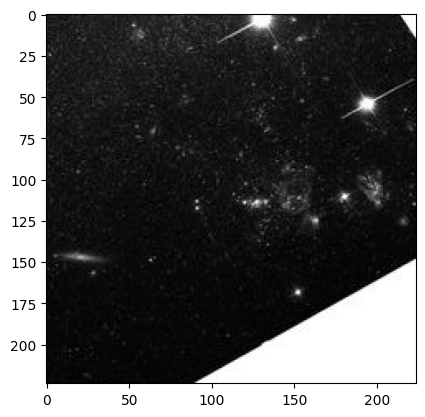

In [52]:
plt.imshow(images[1], vmin=0, vmax=1)

In [53]:
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch16",)

In [55]:
inputs = processor(text=captions, images=(images * 255.), return_tensors="np", padding="max_length", truncation=True, max_length=model.config.text_config.max_length)

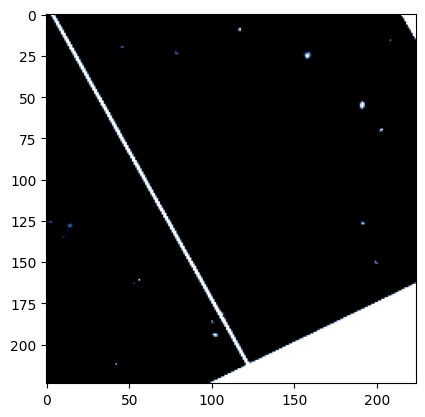

In [283]:
from einops import rearrange
plt.imshow(rearrange(inputs['pixel_values'][3], 'c h w -> h w c'))
# plt.imshow(inputs['pixel_values'][1][2])

In [46]:
import nltk


def sample_and_pad(captions, key, max_length=77):
    sampled_seqs = []

    for caption in captions:
        sentences = nltk.sent_tokenize(caption)
        
        # If the total words are already less than or equal to max_length, just append the caption
        if len(caption.split()) <= max_length:
            sampled_seqs.append(caption)
            continue

        # Get random start index for sentences
        key, subkey = jax.random.split(key)
        start_idx = jax.random.randint(subkey, minval=0, maxval=len(sentences), shape=())

        # Rotate the sentences so that the starting sentence is at the beginning
        rotated_sentences = sentences[start_idx:] + sentences[:start_idx]

        sampled_words = []
        for sent in rotated_sentences:
            if len(sampled_words) + len(sent.split()) <= max_length:
                sampled_words.extend(sent.split())
            else:
                break

        sampled_seq = " ".join(sampled_words)
        sampled_seqs.append(sampled_seq)

    return sampled_seqs

    
key = jax.random.PRNGKey(47)
# [len(cap.split(" ")) for cap in sample_and_pad(caption, key)]

In [47]:
sample_and_pad(caption, key)

['We propose to measure these periods and luminosities by monitoring M51 over 365 d with 34 discrete visits. Simulated observations including the effects of variable stars imply that 50% of pixels will show >2% flux variation over the 365 d baseline.',
 'These observations will allow us to generate spectral energy distributions {SEDs} for a large sample of the SSCs at all ages and extinctions in each system. We will combine the SEDs with population synthesis models and existing ground-based spectra and Spitzer images to estimate ages, reddenings, and masses thus derive a more complete picture of the star-formation histories of the galaxies.',
 "As part of our program, we will also make use of HST's unparalleled UV capabilities to measure the stellar Lyman-alpha emission using STIS, providing an essential input to photochemical models. Category: Planets and Planet Formation. The TESS mission recently uncovered a remarkable multi-planet system consisting of a super-Earth and two temperat

In [67]:
image *= 255

inputs = processor(
    text=caption, images=image, 
    return_tensors="np", 
    padding="max_length",
    truncation=True,
    max_length=77,
)

In [238]:
outputs = model(**inputs, params=model.params)

In [239]:
text_embeds = outputs["text_embeds"]
image_embeds = outputs["image_embeds"]

logits = np.matmul(text_embeds, image_embeds.T)

k = [1, 5, 10, 20]

# Compute the global top-k indices for the maximum k value
max_k = max(k)
top_k_indices = np.argsort(logits, axis=-1)[:, -max_k:]

correct_indices = np.arange(text_embeds.shape[0])[:, None]

metrics = {}
for current_k in k:
    # Check if the correct image (diagonal) is in the current top-k for each text embedding
    correct_in_top_k = np.any(top_k_indices[:, -current_k:] == correct_indices, axis=-1)
    accuracy = np.mean(correct_in_top_k.astype(np.float32))
    metrics[f"top_{current_k}_accuracy"] = accuracy

metrics

{'top_1_accuracy': Array(0.09375, dtype=float32),
 'top_5_accuracy': Array(0.21875, dtype=float32),
 'top_10_accuracy': Array(0.34375, dtype=float32),
 'top_20_accuracy': Array(0.65625, dtype=float32)}

In [240]:
from flax.core import FrozenDict

@partial(jax.pmap, axis_name="batch")
def train_step(state, input_ids, images, attention_mask):
    """Train for a single step."""

    def loss_fn(params):
        outputs = model(input_ids, images, attention_mask, params=params)
        outputs['logit_scale'] = model.params['logit_scale']
        outputs['logit_bias'] = model.params.get('logit_bias', 0.)
        
        loss = sigmoid_loss(outputs)
        return loss

    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    grads = jax.lax.pmean(grads, "batch")
    new_state = state.apply_gradients(grads=grads)
    metrics = {"loss": jax.lax.pmean(loss, "batch")}
    return new_state, metrics


replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

tx = optax.adamw(learning_rate=1e-4)
state = train_state.TrainState.create(
    apply_fn=model.__call__,
    params=FrozenDict(model.params) ,
    tx=tx,
)

pstate = replicate(state)

batch = jax.tree_map(lambda x: np.split(x, num_local_devices, axis=0), inputs.data)
metrics = train_step(pstate, np.array(batch["input_ids"]), np.array(batch["pixel_values"]), np.array(batch["attention_mask"]))

In [241]:
metrics[1]

{'loss': Array([1.42521331, 1.42521331, 1.42521331, 1.42521331], dtype=float64)}